In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Load images 

In [3]:
target_names = ["cat", "dog"]
# Target
y = []
# Data
X = None
# Loop through all .jpg files in a directory
for fn in os.listdir("./animals/"):
    if fn.endswith(".jpg"):
        # Get image 
        im = Image.open("./animals/" + fn).convert("L")
        # Crop image
        half_the_width = im.size[0] / 2
        half_the_height = im.size[1] / 2
        im = im.crop(
            (
                half_the_width - 100,
                half_the_height - 100,
                half_the_width + 100,
                half_the_height + 100
            )
        )
        imd = list(im.getdata())
        # Read images into arrays in data
        # Get first
        if X is None:
            X = np.array(imd)
            h, w = np.array(im).shape
        else:
            X = np.vstack((X, imd))
        # Get targets from file name
        fn = fn.partition(".")
        y.append(target_names.index(fn[0]))

## Image Details

In [4]:
X.shape

(300, 40000)

# Split into train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
X_train.shape

(225, 40000)

# Compute PCA

In [7]:
n_components = 150

pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

In [8]:
eigenanimals = pca.components_.reshape((n_components, h, w))

In [9]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a SCM classification model

In [10]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


# Evaluate the model on the test set 

In [11]:
y_pred = clf.predict(X_test_pca)

## Classification report

In [12]:
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

        cat       0.59      0.26      0.36        38
        dog       0.52      0.81      0.63        37

avg / total       0.55      0.53      0.50        75



## Confusion matrix

In [13]:
print(confusion_matrix(y_test, y_pred, labels=range(len(target_names))))

[[10 28]
 [ 7 30]]


# Show results

In [14]:
def plot_gallery(images, y, h, w, n_row=2, n_col=4, y_names=None):
    """Function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        if y_names:
            plt.title(y_names[y[i]], size=12)
        else:
            plt.title(y[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [15]:
# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

## Train Images

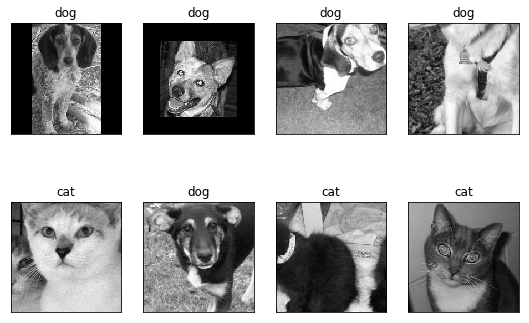

In [16]:
plot_gallery(X_train, y_train, h, w, y_names=target_names)

## Test Images

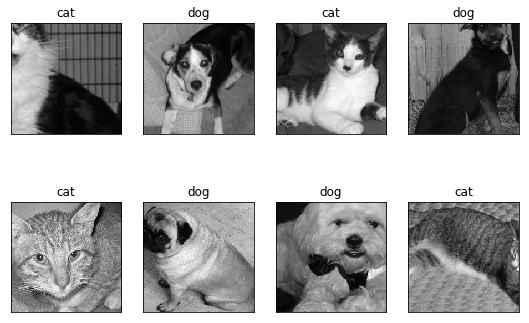

In [17]:
plot_gallery(X_test, y_test, h, w, y_names=target_names)

## Eigenanimals

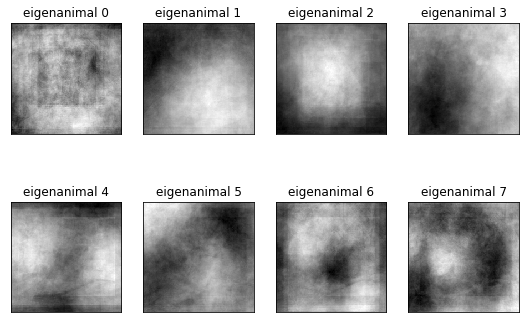

In [18]:
eigenanimal_titles = ["eigenanimal %d" % i for i in range(eigenanimals.shape[0])]
plot_gallery(eigenanimals, eigenanimal_titles, h, w)

## Predictions

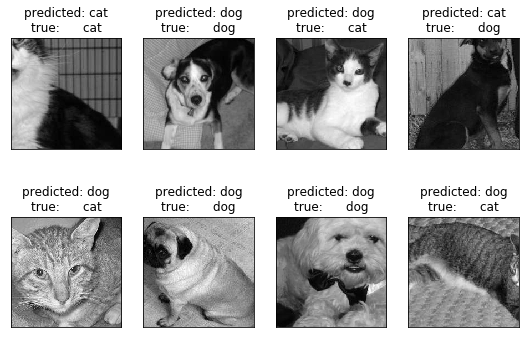

In [19]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)